In [1]:
import sys
sys.path.append('/mnt/disk05/note/workspaces/duxx')
from feature_selector import FeatureSelector
from unity import init_pkg as ini
from unity.eda_func import EdaFunc as edf
from unity.fea_eda_func import FeaEdaFunc as fef
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve
import os
import json
import datetime
import gc
import scorecardpy as sc
# import pandas_profiling

% matplotlib inline

In [53]:
bdbank = ini.pd.read_pickle('data/bd/bdbank.pkl')
bdtag = ini.pd.read_csv('data/tag/bd_tag_avli.csv')

In [54]:
bdbank.head()

,ID,CUST_NAME,ID_CARD_NO,MOBILE_NO,BANK_CARD_NO,CREATED_DATE,UPDATED_DATE,TRANSACTION_TYPE,TRANSACTION_ID,ORDER_NO,INIT_AMOUNT,ANNUAL_INT_RATE,CASH_AMOUNT,AFTER_LMT,BEFORE_LMT,PRE_A_CUST_SEG,zxCreditCardDelqStatus30To60Days,zxHouseFundPayStatus,zxLoanRcyDelqDate,zxDomicile,zx1MthDelqMaxAmt,risCode,zxCreditCardAccuDelqCnt,zxCreditCardDelqStatus90To180Days,zxAccountCnt,zxRcy24MCreCardMaxDelqPeriod,zxHouseFundPayLastMonth,zxCreditCardDelqStatus30Dayyues,r21P12FinallyInterest,zxBadBebtsBalance,zxMaxMonths,zxMaxCreditAmt,zxLoanBalanceAmt,phoneNormalScoreExp3,zxCommerHouseLoanBlance,zxGuaranteeCnt,zxMaxUpdated,zxRcy6MCreCardQueryCompanyCnt,zxCareer,preACustSeg,zxLoanDelqStatus30Dayyues,zxFirstLoanMonth,zxBlanceShouldPayAmt,zxRcy12MCreCardMaxDelqPeriod,zxRestDisposalCnt,zxCreCardUseCreditRate,zxRcy3MCreCardQueryCnt,zxCreCardMaxMonthsCnt,reasonCode,zxRcy6MCreCardQueryCnt,zxCreCardStatus4,zxCreCardStatus5,zxCreCardStatus2,zxCreCardStatus3,zxPermanentAddress,zxLoanCompanyBalCnt,zxWarrantLoanRate1,creditValidityDays,taxMonthlyIncomeSection,zxFirstCreCardDate,zxCreCardStatus1,zxLoanRcyUpdateDate,zxRcy6MLoanQueryCnt,zxWarrantLoanType,zxCreCardDelqAccoutCnt,zxRcy24MAcctMaxDelqPeriod,zxIssuBankCnt,zxLoanDelqStatus6To12Months,zxDelqCnt,zxRcy1MLoanQueryCompanyCnt,initialAmount,zxCreCardNowShouldPayAmt,zxFirstLoanDate,zxLoanDelqStatus60To90Days,reasonMsg,zxRcy1MCreCardQueryCnt,zxRcy6MAvgUseCreditAmt,zxCreditCardRcyUpdateDate,zxRcy24MCreCardTotalDelqCnt,zxEducation,zxRcyQueryDate,dxmAScore,holmesAgentScore,zxHouseFundCompanyRate,prcidNormalScoreExp3,zxLoanDelqStatus90To180Days,zxHouseLoan1MAvgPayAmt,zxRcy3MCreCardQueryCompanyCnt,zxCreditCardDelqStatus6To12Months,zxBadBebtsCnt,zxPersonalLoanCnt,zxCreditBal,zxSex,zxAccountNowTotalDelqAmt,zxHouseFundMonthPayAmt,zxHouseFundSelfRate,zxLoanBalCnt,zxMinCreditAmt,zxTotalCreditAmt,zxMaritalStatus,zxRcy3MLoanQueryCompanyCnt,zxWarrantLoanCnt,zxCreditAvgLimit,blackListType,zxCreditCardDelqStatus60To90Days,zxRcy6MLoanQueryCompanyCnt,zxRcy3MLoanQueryCnt,zxUseCreditAmt,zxCreCardAcctNowTotalDelqAmt,zxCreditRetCode,zxLoanDelqStatus30To60Days,zxRcy1MLoanQueryCnt,zxRcy1MCreCardQueryCompanyCnt,zxHouseFundRecordUpdate,zxWarrantLoanTypeUnnormal,zxHouseFundMonthShouldPayAmt,zxRcy6MCreCardMaxDelqPeriod,zxCreditCardDelqStatus24Months,zxRcy6MAvgPayAmt,bidNormalScoreExp3,zxCreCardDelqMaxAmt,zxCreditCardRcyDelqDate,holmesBlackScore,dailyInterestRate,dailyPenaltyRate,unionLoanUsed,orderId,cashAmount,term,compreAnnualInterestRate,usedTotalLimit,ifLiving,ocrNation,ocrExpdate,ocrSignOrg,photowithidcard,ifIdPicture,idpicture1,idpicture0,livingPhoto
0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,缴交,-9999,福建省厦门市思明区美仁新村14号704室,0,10000,0,N,9,0,2020-02,N,3.0000,-9999,0,160000,3803314,-9999,0,-9999,2020-02-01,0,-9999,A,C,2013-05,19668,0,-9999,0.0395,0,-9999,xiamenguoji-xh-wt,0,正常,-9999,-9999,正常,福建省厦门市思明区美仁新村14号804室,2,-9999,30,05,2014-08-12,正常,2020-02-29,7,-9999,-9999,0,6,N,0,0,3000000,639,2013-05-08,N,-9999,0,11580,2020-02-26,0,本科,2020-03-10 15:15:24,745,51.47,12%,-9999,N,19637,0,N,-9999,0,8070,男,0,2728,12%,3,0,293000,未婚,2,-9999,91000,-9999,N,4,2,8070,0,0000,N,0,0,2020-03-01,-9999,0,0,N,14871,-9999,-9999,-9999,24.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,998a96a170bebb540170c34ca4803ce4,陈欣炜,350424199201300012,1.395012e+10,6217001930010514900,2020-03-10 15:15:44,2020-03-10 15:15:44,apply,1373910714554698083,2202003104111261614804237713_41112616148042377...,3000000.0,0.0,NaN,NaN,NaN,NaN,N,缴交,-9999,福建省福州市鼓楼区白马花园15幢2单元603室,0,10000,0,N,4,0,2019-12,N,4.5000,-9999,0,38000,-9999,-9999,-9999,-9999,2020-01-01,0,-9999,A,-9999,-9999,0,0,-9999,0.0361,0,-9999,xiamenguoji-xh-wt,0,-9999,-9999,-9999,-9999,福建省南平市武夷山市站区南路18号家属区,-9999,-9999,30,04,2019-01-23,正常,-9999,0,-9999,-9999,-9999,3,-9999,0,0,5150000,650,-9999,-9999,-9999,0,2202,2020-03-04,0,本科,2020-03-11 14:20:41,675,0,12%,-9999,-9999,-9999,0,N,-9999,-9999,4298,女,-9999,1538,12%,-9999,11000,61000,未婚,0,-9999,25000,-9999,N,0,0,4298,0,0000,-9999,0,0,2

In [55]:
bdtag.head()

,dubil_no,cert_no,ovdue_days,lon_dt
0,4176499214121897291,350521197206100033,0,2020-04-02
1,4176498286408975032,640321198510110730,0,2020-03-29
2,4170320439806389279,12022219960310582X,0,2020-03-26
3,4149489607891218124,441623199705305789,0,2020-03-23
4,4176499660798518798,110102197111170818,0,2020-04-02


In [56]:
bdtag['tag'] = 0
bdtag.loc[bdtag['ovdue_days']>30,'tag'] = 1

In [57]:
bdbank = bdbank.sort_values(['ID_CARD_NO','CREATED_DATE'],ascending=[0,1]).drop_duplicates('ID_CARD_NO',keep='first')

In [7]:
bdbank = bdbank.dropna(subset=['ID','ID_CARD_NO'])
bdbank = bdbank.rename({'ID_CARD_NO':'cert_no'},axis=1)
bdmain = bdbank.merge(bdtag,on='cert_no')
del bdbank,bdtag

# 一、数据清洗

## 1.1 剔除单一值、缺失>0.7、相关性>0.7

In [8]:
drop_feas = {'ID','BANK_CARD_NO','MOBILE_NO','TRANSACTION_ID','CUST_NAME','ORDER_NO','idpicture0','livingPhoto',
             'photowithidcard','orderId','CREATED_DATE','reasonMsg','unionLoanUsed','TRANSACTION_TYPE','zxSex',
             'TRANSACTION_ID','ovdue_days','BANK_CARD_NO','dubil_no','UPDATED_DATE','zxDomicile','zxPermanentAddress'}

bdmain = bdmain.replace([-9999,'-9999'],ini.np.nan)

In [9]:
fs = FeatureSelector(data=bdmain.drop('tag',axis=1),labels=bdmain['tag'])
fs.identify_missing(0.7)
fs.identify_single_unique()
fs.identify_collinear(0.7)
fs_drop = fs.check_removal()

30 features with greater than 0.70 missing values.

8 features with a single unique value.

0 features with a correlation magnitude greater than 0.70.

Total of 34 features identified for removal


In [10]:
drop_feas = drop_feas | set(fs_drop)

In [11]:
bdmain = bdmain.drop(drop_feas,axis=1)

In [52]:
bdmain.shape

(69422, 95)

## 1.2 异常值处理

In [12]:
# bdmain = bdmain.replace([-9999,'-9999'],ini.np.nan)

## 1.3 划分数据集

In [13]:
train_x,test_x,train_y,test_y = train_test_split(bdmain,bdmain['tag'],test_size=0.3,shuffle=True,random_state=123)

In [14]:
train_x['tag'].value_counts()

0    48144
1      451
Name: tag, dtype: int64

In [15]:
test_x['tag'].value_counts()

0    20631
1      196
Name: tag, dtype: int64

# 二、特征工程

## 2.1 日期、百分比、地址特征处理

### 2.1.1 日期特征衍生

In [16]:
date_feas = train_x.loc[:,train_x.columns.str.contains('Date|LastMonth|lon_dt|FirstLoan|Update')].columns

In [17]:
date_feas

Index(['zxHouseFundPayLastMonth', 'zxMaxUpdated', 'zxFirstLoanMonth',
       'zxFirstCreCardDate', 'zxLoanRcyUpdateDate', 'zxFirstLoanDate',
       'zxCreditCardRcyUpdateDate', 'zxRcyQueryDate',
       'zxHouseFundRecordUpdate', 'zxCreditCardRcyDelqDate', 'lon_dt'],
      dtype='object')

In [18]:
train_x[date_feas].dtypes

zxHouseFundPayLastMonth      object
zxMaxUpdated                 object
zxFirstLoanMonth             object
zxFirstCreCardDate           object
zxLoanRcyUpdateDate          object
zxFirstLoanDate              object
zxCreditCardRcyUpdateDate    object
zxRcyQueryDate               object
zxHouseFundRecordUpdate      object
zxCreditCardRcyDelqDate      object
lon_dt                       object
dtype: object

In [19]:
train_x['zxHouseFundPayLastMonth'] = train_x['zxHouseFundPayLastMonth'].replace('0002-12',ini.np.nan)
test_x['zxHouseFundPayLastMonth'] = test_x['zxHouseFundPayLastMonth'].replace('0002-12',ini.np.nan)
train_x.loc[:,date_feas] = train_x[date_feas].astype('datetime64[ns]')
test_x.loc[:,date_feas] = test_x[date_feas].astype('datetime64[ns]')

In [20]:
for c in date_feas[:-1]:
    train_x[f'{c}_diff_londt'] = abs((train_x['lon_dt'] - train_x[c]).dt.days)
    test_x[f'{c}_diff_londt']  = abs((test_x['lon_dt'] - test_x[c]).dt.days)

In [21]:
train_x = train_x.drop(date_feas,axis=1)
test_x = test_x.drop(date_feas,axis=1)

### 2.1.2 比例特征处理

In [22]:
train_x['zxHouseFundCompanyRate'] = train_x['zxHouseFundCompanyRate'].str.extract('(\d+)').astype(float)/100
train_x['zxHouseFundSelfRate'] = train_x['zxHouseFundSelfRate'].str.extract('(\d+)').astype(float)/100
test_x['zxHouseFundCompanyRate'] = test_x['zxHouseFundCompanyRate'].str.extract('(\d+)').astype(float)/100
test_x['zxHouseFundSelfRate'] = test_x['zxHouseFundSelfRate'].str.extract('(\d+)').astype(float)/100

### 2.1.3 地址特征处理

In [23]:
train_x = fef.build_cert_refer_feas(train_x,cert_cols='cert_no')
test_x = fef.build_cert_refer_feas(test_x,cert_cols='cert_no')

## 2.2 类别特征处理

In [24]:
def bin_group_single(df, col, target):
    """
    单个特征iv,woe
    """
    regroup = df.groupby([col])['tag'].agg(['count','sum']).replace(0,0.9)\
                .rename({'count':'total','sum':'bad'},axis=1)\
                .assign(variable=col,
                        good=lambda x:x['total']-x['bad'],
                        badprob = lambda x:x['bad']/x['total'],
                        DistrBad = lambda x:x['good']/sum(x['good']),
                        DistrGood = lambda x:x['bad']/sum(x['bad']),
                        woe = lambda x:ini.np.log(x['DistrBad']/x['DistrGood']),
                        bin_iv = lambda x:(x['DistrBad']-x['DistrGood'])*x['woe'],
                        total_iv = lambda x:sum(x.bin_iv))
    regroup.reset_index(level=0,inplace=True)
    return regroup

def bin_group(df, cols, target,return_type='badrate',missing=True):
    """
    """
    bin_df_dicts = {}
    if missing: df.loc[:,cols] = df.fillna('missing')
    for c in cols:
        bin_df = bin_group_single(df,c,target)
        bin_df_dicts[c] = bin_df
    return bin_df_dicts

def badrate_ply(df,cols, bin_df_dicts,missing=True):
    """
    badrate编码转化
    """
    if missing: df.loc[:,cols] = df.fillna('missing')
    bin_badp_dicts = {c:dict(zip(bin_df_dicts[c][c],bin_df_dicts[c]['badprob'])) for c in cols}
    df.replace(bin_badp_dicts,inplace=True)
    return df

In [25]:
train_x = train_x.loc[:,train_x.columns.str.contains('zx|tag')]
test_x = test_x.loc[:,test_x.columns.str.contains('zx|tag')]

In [26]:
cat_feas = set(train_x.loc[:,train_x.columns.str.contains('Status|Type|Code|Sex|Seg|LoanUse|Section|ocr|Edu|Career|Mari')].columns)

In [27]:
cat_feas_info = edf.get_features_type(train_x[cat_feas])['cat_feas']

In [28]:
cat_feas_info

zxCreditCardDelqStatus90To180Days    13
zxEducation                           8
zxMaritalStatus                       5
zxLoanDelqStatus30Dayyues            10
zxHouseFundPayStatus                  4
zxCreditCardDelqStatus30Dayyues      12
zxCreCardStatus3                      6
zxLoanDelqStatus6To12Months          12
zxLoanDelqStatus30To60Days           14
zxCreditCardDelqStatus24Months       13
zxLoanDelqStatus60To90Days           14
zxCareer                             10
zxCreditRetCode                       3
zxCreditCardDelqStatus6To12Months    13
zxCreCardStatus4                      5
zxCreCardStatus1                      7
zxCreditCardDelqStatus30To60Days     13
zxLoanDelqStatus90To180Days          14
zxCreditCardDelqStatus60To90Days     13
zxCreCardStatus5                      7
dtype: int64

* <font color=red face=仿宋 size=4>lightgbm测试</font>

In [29]:
train_x.loc[:,cat_feas_info.index] = train_x.astype('category')
test_x.loc[:,cat_feas_info.index] = test_x.astype('category')

obj_feas = train_x.select_dtypes(include=['object','int']).columns
train_x.loc[:,obj_feas] = train_x[obj_feas].astype(float)
test_x.loc[:,obj_feas] = test_x[obj_feas].astype(float)
train_x = train_x.drop('tag',axis=1)
test_x = test_x.drop('tag',axis=1)
from lightgbm import LGBMClassifier
lgbc = LGBMClassifier(random_state=123,is_unbalanced=True,num_leaves=10,max_depth=8)
lgbc.fit(train_x,train_y)

predict_train_y = lgbc.predict_proba(train_x)[:,1]
print(roc_auc_score(train_y,predict_train_y))
predict_test_y = lgbc.predict_proba(test_x)[:,1]
print(roc_auc_score(test_y,predict_test_y))

0.9622621649095582
0.7206967125951733


* <font color=red face=仿宋 size=4>GBDT+LR测试</font>

In [30]:
# 获取树节点
gbdt_tree = lgbc.booster_
tree_train_x = gbdt_tree.predict(train_x,pred_leaf=True)
tree_test_x = gbdt_tree.predict(test_x,pred_leaf=True)

In [31]:
# 对特征树节点ONEHOT编码
onehot = OneHotEncoder()
onehot.fit(tree_train_x)
gbdt_train_x = onehot.transform(tree_train_x)
gbdt_test_x = onehot.transform(tree_test_x)

In [32]:
# 用转化后的特征训练LR
lr = LogisticRegression()
lr.fit(gbdt_train_x,train_y)
predict_test_y = lr.predict_proba(gbdt_test_x)[:,1]

In [47]:
gbdt_test_x.A[:5,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

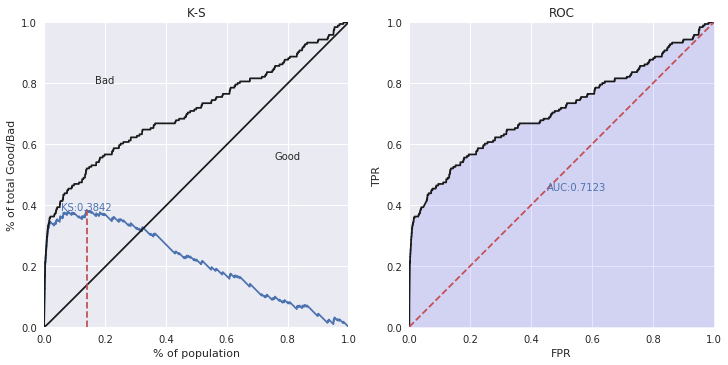

{'AUC': 0.7123,
 'Gini': 0.4247,
 'KS': 0.3842,
 'pic': <Figure size 864x432 with 2 Axes>}

In [33]:
sc.perf_eva(test_y,predict_test_y)

* <font color=red face=仿宋 size=4>FFM+LR测试</font>

,zxCreditCardDelqStatus30To60Days,zxHouseFundPayStatus,zx1MthDelqMaxAmt,zxCreditCardAccuDelqCnt,zxCreditCardDelqStatus90To180Days,zxAccountCnt,zxRcy24MCreCardMaxDelqPeriod,zxCreditCardDelqStatus30Dayyues,zxMaxMonths,zxMaxCreditAmt,zxLoanBalanceAmt,zxCommerHouseLoanBlance,zxRcy6MCreCardQueryCompanyCnt,zxCareer,zxLoanDelqStatus30Dayyues,zxBlanceShouldPayAmt,zxRcy12MCreCardMaxDelqPeriod,zxCreCardUseCreditRate,zxRcy3MCreCardQueryCnt,zxCreCardMaxMonthsCnt,zxRcy6MCreCardQueryCnt,zxCreCardStatus4,zxCreCardStatus5,zxCreCardStatus3,zxLoanCompanyBalCnt,zxCreCardStatus1,zxRcy6MLoanQueryCnt,zxCreCardDelqAccoutCnt,zxRcy24MAcctMaxDelqPeriod,zxIssuBankCnt,zxLoanDelqStatus6To12Months,zxDelqCnt,zxRcy1MLoanQueryCompanyCnt,zxCreCardNowShouldPayAmt,zxLoanDelqStatus60To90Days,zxRcy1MCreCardQueryCnt,zxRcy6MAvgUseCreditAmt,zxRcy24MCreCardTotalDelqCnt,zxEducation,zxHouseFundCompanyRate,zxLoanDelqStatus90To180Days,zxHouseLoan1MAvgPayAmt,zxRcy3MCreCardQueryCompanyCnt,zxCreditCardDelqStatus6To12Months,zxPersonalLoanCnt,zxCreditBal,zxAccountNowTotalDelqAmt,zxHouseFundMonthPayAmt,zxHouseFundSelfRate,zxLoanBalCnt,zxMinCreditAmt,zxTotalCreditAmt,zxMaritalStatus,zxRcy3MLoanQueryCompanyCnt,zxCreditAvgLimit,zxCreditCardDelqStatus60To90Days,zxRcy6MLoanQueryCompanyCnt,zxRcy3MLoanQueryCnt,zxUseCreditAmt,zxCreCardAcctNowTotalDelqAmt,zxCreditRetCode,zxLoanDelqStatus30To60Days,zxRcy1MLoanQueryCnt,zxRcy1MCreCardQueryCompanyCnt,zxHouseFundMonthShouldPayAmt,zxRcy6MCreCardMaxDelqPeriod,zxCreditCardDelqStatus24Months,zxRcy6MAvgPayAmt,zxCreCardDelqMaxAmt,zxHouseFundPayLastMonth_diff_londt,zxMaxUpdated_diff_londt,zxFirstLoanMonth_diff_londt,zxFirstCreCardDate_diff_londt,zxLoanRcyUpdateDate_diff_londt,zxFirstLoanDate_diff_londt,zxCreditCardRcyUpdateDate_diff_londt,zxRcyQueryDate_diff_londt,zxHouseFundRecordUpdate_diff_londt,zxCreditCardRcyDelqDate_diff_londt
21438,*,1,0.0,0.0,N,2.0,0.0,*,0.0,35000.0,900566.0,0.0,1.0,NaN,C,5364.0,0.0,0.1679,0.0,NaN,1.0,3,提前结清,正常,2.0,正常,1.0,NaN,0.0,1.0,N,0.0,0.0,0.0,N,0.0,5878.0,0.0,大专,0.12,N,5364.0,0.0,/,0.0,6175.0,0.0,624.0,0.12,2.0,35000.0,35000.0,1,0.0,35000.0,N,1.0,0.0,6175.0,0.0,0,N,0.0,0.0,0.0,0.0,/,5366.0,NaN,96.0,65.0,1010.0,189.0,36.0,981.0,47.0,24.0,65.0,NaN
48209,N,1,0.0,1.0,N,29.0,0.0,C,0.0,85241.0,153833.0,0.0,1.0,商业、服务业人员,C,2833.0,0.0,0.8772,0.0,1.0,1.0,3,NaN,正常,2.0,正常,1.0,1.0,0.0,10.0,N,0.0,0.0,37921.0,N,0.0,320784.0,0.0,本科,0.12,N,0.0,0.0,C,0.0,335364.0,0.0,2146.0,0.12,2.0,6000.0,365693.0,0,1.0,26576.0,N,1.0,1.0,335364.0,0.0,0,N,0.0,0.0,0.0,0.0,C,2361.0,3642.0,61.0,21.0,2830.0,5198.0,21.0,2803.0,15.0,5.0,61.0,1827.0
58835,N,0,0.0,0.0,N,4.0,0.0,N,0.0,12000.0,12571.0,0.0,0.0,NaN,C,3341.0,0.0,0.3471,0.0,NaN,0.0,3,提前还款,正常,3.0,正常,0.0,NaN,0.0,3.0,N,0.0,0.0,3999.0,N,0.0,7116.0,0.0,未知,0.05,N,NaN,0.0,N,0.0,9669.0,0.0,0.0,0.05,5.0,3000.0,20500.0,1,0.0,6833.0,N,0.0,0.0,9669.0,0.0,0,N,0.0,0.0,0.0,0.0,N,2236.0,NaN,440.0,74.0,683.0,729.0,7.0,670.0,7.0,4.0,74.0,NaN
13189,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42679,NaN,3,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,58427.0,0.0,0.0,不便分类的其他从业人员,C,2129.0,NaN,NaN,0.0,NaN,0.0,3,提前还款,正常,5.0,NaN,2.0,NaN,0.0,NaN,N,0.0,1.0,NaN,N,0.0,NaN,NaN,未知,NaN,N,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,6.0,NaN,NaN,1,2.0,NaN,NaN,2.0,2.0,NaN,NaN,0,N,1.0,0.0,0.0,NaN,NaN,2513.0,NaN,NaN,50.0,1294.0,NaN,48.0,1286.0,NaN,32.0,NaN,NaN
27197,*,1,0.0,0.0,*,5.0,0.0,*,0.0,8000.0,NaN,0.0,1.0,未知,C,0.0,0.0,0.0000,0.0,NaN,1.0,4,提前还款,结清,NaN,正常,1.0,NaN,0.0,3.0,N,0.0,0.0,0.0,N,0.0,0.0,0.0,大专,0.12,N,NaN,0.0,N,0.0,0.0,0.0,504.0,0.12,NaN,4000.0,26000.0,0,0.0,8667.0,*,1.0,0.0,0.0,0.0,0,N,0.0,0.0,0.0,0.0,N,NaN,NaN,99.0,162.0,495.0,2820.0,126.0,487.0,35.0,30.0,70.0,NaN
42061,N,3,0.0,0.0,N,15.0,0.0,C,0.0,50000.0,133921.0,0.0,0.0,NaN,C,0.0,0.0,0.7088,0.0,NaN,0.0,3,提前结清,正常,1.0,正常,9.0,NaN,0.0,8.0,N,0